In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas
import seaborn as sns
import os

# Unpack experiments

In [2]:
# Specify what you're looking at
exp = 'beta'
search_style = 'narrow'

In [3]:
exp_dir = f'/Volumes/aronov-locker/Ching/barcodes/{exp}/'
N_inp = 5000
N_bar = 5000
num_states = 100
decay_constant = 0.2
cache_states = [20, 30, 70]

In [4]:
def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

def distance(a, b, maximum):
    dist = np.abs(a - b)
    dist = min(dist, np.abs(maximum-dist))
    return dist

def normalize(x):
    return (x -np.mean(x, axis=1, keepdims=True))/ (1e-8+np.std(x, axis=1, keepdims=True))

def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def run_dynamics(W, inputs,  dt=0.1, b=0.0):
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-dt) + dt*(np.matmul(acts, W))+dt*inputs
        preacts = normalize(preacts)
        acts = relu(preacts, b=b)
    return normalize(preacts), acts

In [5]:
inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        dist = distance(n, peak, N_inp)
        inputs[s, n] = np.exp(-(dist/(N_inp*decay_constant)))

In [6]:
def get_reconstruct_stats(reconstruct):
    argmax_v = np.argmax(reconstruct, axis=1)
    argmax_v = (argmax_v/N_inp)*num_states
    max_v = np.max(reconstruct, axis=1)
    threshold_scale = 1.
    threshold = reconstruct.mean()+threshold_scale*reconstruct.std()

    attractor_dist = []
    opt_attractor_dist = []
    attractor_locs = []
    attractor_validity = []
    state_locs = []
    for loc, _v in enumerate(argmax_v):
        if max_v[loc] < threshold:
            _v = -1
        _opt_dist = min([distance(loc, c, num_states) for c in cache_states])
        opt_attractor_dist.append(_opt_dist)
        state_locs.append(loc)
        if _v in cache_states:
            attractor_dist.append(distance(loc, _v, num_states))
            attractor_locs.append(_v)
            attractor_validity.append(1)
        else:
            attractor_dist.append(np.nan)
            attractor_locs.append(np.nan)
            attractor_validity.append(-1)
    attractor_dist = np.array(attractor_dist)
    attractor_locs = np.array(attractor_locs)
    attractor_validity = np.array(attractor_validity)
    opt_attractor_dist = np.array(opt_attractor_dist)
    state_locs = np.array(state_locs)
    return attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist, state_locs

In [7]:
results_1 = {
    'param': [],
    'seed': [],
    'valid_attractors': [],
    'valid_20_30_attractors': [],
    }
results_2A = {
    'param': [],
    'seed': [],
    'opt attractor dist': [],
    'probability': []
    }
results_2B = {
    'param': [],
    'seed': [],
    'opt attractor dist': [],
    'chosen attractor dist': []
    }
results_2C = {
    'param': [],
    'seed': [],
    'cache': [],
    'probability': [],
    }
results_3 = {
    'param': [],
    'seed': [],
    'distance': [],
    'barcode corr': []
    }
results_4 = {
    'param': [],
    'seed': [],
    'place-barcode corr': []
    }

for param in os.listdir(exp_dir):
    if param == '.DS_Store': continue
    seed_count = 0
    for seed in os.listdir(exp_dir + param):
        if seed_count > 3: break
        if seed == '.DS_Store': continue
        seed_count += 1
        _exp_dir = exp_dir + param + '/' + seed + '/'
        print('Loading')
        with open(_exp_dir + 'results.p', 'rb') as f:
            _results = pickle.load(f)
        attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist, state_locs = \
            get_reconstruct_stats(_results[f'{search_style}_reconstruct'])
        
        # Test 1
        print('Test 1')
        valid = np.sum(attractor_validity==1)/attractor_validity.size
        v = attractor_validity[np.logical_and(state_locs>20, state_locs<30)]
        valid_20_30 = np.sum(v==1)/v.size
        results_1['param'].append(float(param))
        results_1['seed'].append(seed)
        results_1['valid_attractors'].append(valid)
        results_1['valid_20_30_attractors'].append(valid_20_30)
        
        # Test 2A
        print('Test 2A')
        for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
            idxs = opt_attractor_dist==_opt_dist
            _validity = attractor_validity[idxs]
            valid = np.sum(_validity==1)/_validity.size
            results_2A['param'].append(float(param))
            results_2A['seed'].append(seed)
            results_2A['opt attractor dist'].append(_opt_dist)
            results_2A['probability'].append(valid)
            
        # Test 2B
        print('Test 2B')
        attractor_dist = attractor_dist[attractor_validity==1]
        attractor_locs = attractor_locs[attractor_validity==1]
        opt_attractor_dist = opt_attractor_dist[attractor_validity==1]
        for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
            idxs = opt_attractor_dist==_opt_dist
            _chosen_dist = np.mean(attractor_dist[idxs]) - _opt_dist
            results_2B['param'].append(float(param))
            results_2B['seed'].append(seed)
            results_2B['opt attractor dist'].append(_opt_dist)
            results_2B['chosen attractor dist'].append(_chosen_dist)
            
        # Test 2C
        print('Test 2C')
        for idx, cache_state in enumerate(cache_states):
            p = np.sum(attractor_locs==cache_state)/attractor_locs.size
            results_2C['param'].append(float(param))
            results_2C['seed'].append(seed)
            results_2C['cache'].append(cache_state)
            results_2C['probability'].append(p)
            
        # Test 3
        print('Test 3')
        acts = _results[f'{search_style}_acts']
        c = pairwise_correlations_centered(acts)
        distances = []; correlations = []
        for i in range(c.shape[0]):
            for j in range(c.shape[1]):
                distances.append(distance(i, j, num_states))
                correlations.append(c[i,j])
        distances = np.array(distances); correlations = np.array(correlations)
        for _dist in np.unique(distances):
            idxs = distances==_dist
            _corr = np.mean(correlations[idxs])
            results_3['param'].append(float(param))
            results_3['seed'].append(seed)
            results_3['distance'].append(_dist)
            results_3['barcode corr'].append(_corr)
            
        # Test 4
        print('Test 4')
        acts_normalized = normalize(acts)
        inputs_normalized = normalize(inputs)
        corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
        results_4['param'].append(float(param))
        results_4['seed'].append(seed)
        results_4['place-barcode corr'].append(np.mean(corrs))

Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3
Test 4
Loading
Test 1
Test 2A
Test 2B
Test 2C
Test 3


# Test 1

In [9]:
import configs

In [12]:
import pandas as pd

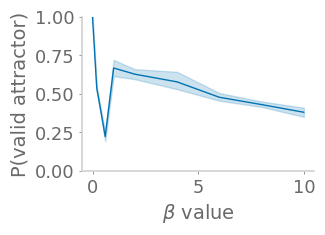

In [23]:
data = pd.DataFrame(results_1)

plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='valid_attractors', data=data)
plt.xlabel(r'$\beta$ value')
plt.ylabel('P(valid attractor)')
plt.ylim(0, 1.0)
plt.show()

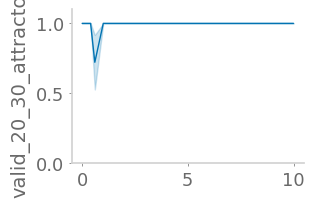

In [14]:
plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='valid_20_30_attractors', data=data)
plt.ylim(0, 1.1)
plt.xlabel('')
plt.show()

# Test 2

In [15]:
import importlib
importlib.reload(configs)

<module 'configs' from '/Users/chingfang/Code/barcodes/configs.py'>

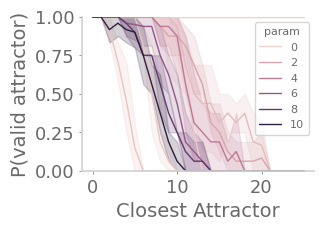

In [16]:
data = pd.DataFrame(results_2A)
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='probability', hue='param', data=data)
plt.ylim(0, 1.0)
plt.xlabel('Closest Attractor')
plt.ylabel('P(valid attractor)')
plt.show()

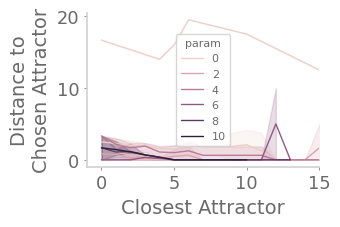

In [17]:
data = pd.DataFrame(results_2B)
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='chosen attractor dist', hue='param', data=data)
plt.xlim(-1, 15)
plt.xlabel('Closest Attractor')
plt.ylabel('Distance to\nChosen Attractor')
plt.show()

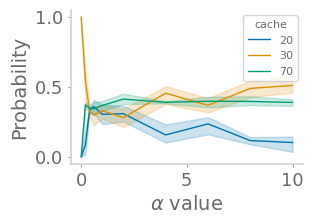

In [18]:
data = pd.DataFrame(results_2C)

plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='probability', hue='cache', data=data, palette=['C0', 'C1', 'C2'])
plt.xlabel(r'$\alpha$ value')
plt.ylabel('Probability')
plt.show()

# Test 3

In [19]:
data = pd.DataFrame(results_3)

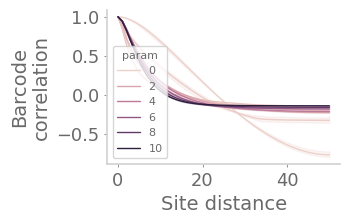

In [20]:
plt.figure(figsize=(3,2))
sns.lineplot(x='distance', y='barcode corr', hue='param', data=data)
plt.xlabel('Site distance')
plt.ylabel('Barcode\ncorrelation')
plt.show()

# Test 4

In [21]:
data = pd.DataFrame(results_4)

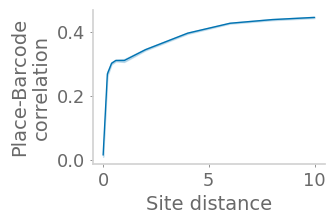

In [22]:
plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='place-barcode corr', data=data)
plt.xlabel('Site distance')
plt.ylabel('Place-Barcode\ncorrelation')
plt.show()